# The Five Minute Introduction to SeqLike

This notebook aims to teach you, in under 5 minutes worth of reading, all about SeqLike and its major features.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd 


from seqlike import SeqLike, ntSeqLike, aaSeqLike
from seqlike.alphabets import STANDARD_NT, STANDARD_AA

Loading BokehJS ...

## What is SeqLike all about?

SeqLike aims to be an omnibus Python object
that bridges between different sequence representations:
strings, SeqRecord objects, NumPy arrays, and more.
It draws heavily upon BioPython's SeqRecord objects, and in 
most cases can be a drop-in replacement with additional powerful features
that bioinformaticians familiar with BioPython
will absolutely love ❤️.  

### What problems do SeqLike solve?

At its core, SeqLike solves the following problems:

1. Sequence representation inter-conversion (AA vs. NT, and str/Seq/SeqRecord/arrays) via a single object's API.
2. Convenience APIs to manipulate and/or visualize of a collection of sequences.

## Sequence Representation

### Constructing SeqLike objects

SeqLikes can be constructed from nucleotide or protein sequences with an explicit sequence type set.  They can wrap string, Seq, SeqRecord, and list/arrays: anything that is _like a sequence_.  This will be clear as we proceed, but for now, we'll just demonstrate with strings:

In [2]:
aa_sequence = "PKSAAEKAGLKAGDPKSAAEKAGLKAGDPKSAAEKAGLKAGDPKSAAEKAGLKAGD"
s_aa = SeqLike(aa_sequence, seq_type="aa") # case insensitive

nt_sequence = "AUCTCUCUAUTACUA"
s_nt = SeqLike(nt_sequence, seq_type="nt")  # case insensitive, can be "nt", "dna", or "rna"

If you know the sequence type ahead of time, we recommend using the helper functions ntSeqLike and aaSeqLike for convenience.  These are not subtypes, but functions that return SeqLike objects of the apropriate seq_type, coercing if necessary.  

In [3]:
s_aa = aaSeqLike(aa_sequence)
s_nt = ntSeqLike(nt_sequence)

s_aa_coerced = aaSeqLike(nt_sequence)  # every NT sequence is a valid AA SeqLike with the default alphabets...

try:
    s_nt_coerced = ntSeqLike(aa_sequence)  # In contrast, virtually every AA sequence is NOT a valid NT SeqLike!
except TypeError as e:
    print(e)


Invalid DNA or RNA sequence!


The SeqLike `__repr__` (string representing) gives us lots of useful information about the sequence.
This one has no nucleotide representation, it has an amino acid representation, and the amino acid representation has an auto-generated ID, 
unknown name, and unknown description. 

In [4]:
s_aa

NT: None 

*** AA: SeqRecord(seq=Seq('PKSAAEKAGLKAGDPKSAAEKAGLKAGDPKSAAEKAGLKAGDPKSAAEKAGLKAGD'), id='65facf36-bf07-4962-8493-a67fb390b990', name='<unknown name>', description='<unknown description>', dbxrefs=[])

### Working with SeqLikes with dual NT and AA representations 

For many workflows, it is powerful to maintain a dual representation of a sequence with AA and NT forms.  SeqLike supports this, and has a notion of the "current" sequence type.  All methods (e.g. sub-indexing) act on the current sequence type, but are reflected in the non-active type.

Given a DNA or RNA sequence, as long as the nucleotide sequence is a multiple of 3, you can always convert it to the amino acid representation.

In [5]:
s_aa = s_nt.aa()

print(s_aa.__repr__()) # current form marked by ***

# Note: s_nt is unchanged, we alwas return copies
print(f"\n{id(s_nt)=}, {id(s_aa)=}")

NT: SeqRecord(seq=Seq('AUCTCUCUAUTACUA'), id='bd6124f7-62ee-414c-b788-a5f98625cc82', name='<unknown name>', description='<unknown description>', dbxrefs=[]) 

*** AA: SeqRecord(seq=Seq('ISLLL'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])

id(s_nt)=139681557569296, id(s_aa)=139680518963264


If the length is not a multiple of 3, then translation is disallowed:

In [6]:
try:
    s_nt[:-1].aa()
except TypeError as e:
    print(e)


Oh no! It looks like you're trying to translate a nucleotide sequence whose length is not a multiple of 3. As a safeguard, SeqLike objects do not allow this to happen. 


In contrast to translation, back-translation is ambigious and ill-defined because there are multiple valid codons for each amino acid.  For instance, the amino acid leucine can be encoded in RNA as CUU, CUC, CUA, and CUG.

Therefore, to use `.nt()`, you must use a callable that takes an AA sequence and returns a sequence in NT form.  We've included several codon tables (implemented as dictionaries) and associated codon maps (implemented as callables) in `codon_tables.py`.  If you don't provide a codon_map, we raise an error.

In [7]:
from seqlike.codon_tables import human_codon_map

try:
    s_aa = aaSeqLike(aa_sequence)    
    s_aa.nt()
except AttributeError as e:
    print(e)
    
print("\n")

s_aa = aaSeqLike(aa_sequence, codon_map=human_codon_map)
s_aa.nt()

No callable passed and self.codon_map not set!  Please set the codon_map attribute or pass in a callable using the `codon_map` keyword.




*** NT: SeqRecord(seq=Seq('CCAAAAAGCGCAGCAGAAAAAGCAGGACTAAAAGCAGGAGACCCAAAAAGCGCA...GAC'), id='9db2d878-cc38-4039-8f13-bef1f2fcd7f8', name='<unknown name>', description='<unknown description>', dbxrefs=[]) 

AA: SeqRecord(seq=Seq('PKSAAEKAGLKAGDPKSAAEKAGLKAGDPKSAAEKAGLKAGDPKSAAEKAGLKAGD'), id='9db2d878-cc38-4039-8f13-bef1f2fcd7f8', name='<unknown name>', description='<unknown description>', dbxrefs=[])

A final note:  `.aa()` and `.nt()` call `.translate()` and `.back_translate()` internally _if needed_.  If the SeqLike has both an AA and an NT, then `.aa()` and `.nt()` just swap the active form of the sequence and return a copy.

### Manipulating SeqLikes with NT and AA representations (slicing, padding, etc.)

In general, all typical sequence methods work on the current active form of the sequence.  For example, if you have an AA SeqLike and you slice it, it will return an AA SeqLike where the NT form as been sliced as well.

In [8]:
s_nt = SeqLike(nt_sequence, seq_type='nt')
s_aa = s_nt.aa()

s_aa[:3].nt()

*** NT: SeqRecord(seq=Seq('AUCTCUCUA'), id='ce9fd137-cfaa-4bce-9e50-10eb18132bc5', name='<unknown name>', description='<unknown description>', dbxrefs=[]) 

AA: SeqRecord(seq=Seq('ISL'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])

When you slice an NT SeqLike that has an AA representation, 
as long as you slice in-frame, you will slice the AA representation as well.

In [9]:
s_nt.aa().nt()[0:6]

*** NT: SeqRecord(seq=Seq('AUCTCU'), id='ce9fd137-cfaa-4bce-9e50-10eb18132bc5', name='<unknown name>', description='<unknown description>', dbxrefs=[]) 

AA: SeqRecord(seq=Seq('IS'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])

Slicing out of frame will give you weird behaviour;
BioPython will give you a warning,
though it's up to you to know what you're doing.

In [10]:
s_nt.aa().nt()[0:4]

/opt/install/conda/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


*** NT: SeqRecord(seq=Seq('AUCT'), id='ce9fd137-cfaa-4bce-9e50-10eb18132bc5', name='<unknown name>', description='<unknown description>', dbxrefs=[]) 

AA: SeqRecord(seq=Seq('I'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])

Finally, here is example usage of a couple of miscellaneous methods:

In [11]:
# operates on the nt
print(f"{len(s_nt)=}")

# operates on the aa
print(f"{len(s_nt.aa())=}")

# pads the nt, adding a gap character "-"
print(s_nt.pad_to(18))

# pads the aa, using the same gap character "-"
print(s_nt.aa().pad_to(18))

len(s_nt)=15
len(s_nt.aa())=5
AUCTCUCUAUTACUA---
ISLLL-------------


### Initialization from and conversion between different datatypes

For machine learning purposes, sequences need to be encoded numerically.  This is typically done by encoding each letter in the sequence in two ways:  

1. as a one-hot categorical distribution over alphabet symbols (one hot encoding)
2. as an integer-valued index over alphabet symbols (index encoding)

SeqLike has robust support for both.  Crucially, numercial representations require an ordered alphabet to map between letter and number.  We provide a default, but See `alphabets.py` for more.

In [12]:
# Manually create many data structures representing the same sequence

s_str = 'ACGTTT'
s_seq = Seq(s_str)
s_seqrecord = SeqRecord(s_seq)

s_onehot = [[0, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0, 0]]
s_index = [1, 2, 3, 4, 4, 4]


In [13]:

for rep in [s_str, s_seq, s_seqrecord, s_onehot, s_index]:
    # Default alphabet for NT is "-ACGTUN".  See alphabets.py for more.
    s_rep = ntSeqLike(rep, alphabet=STANDARD_NT)  
 
    assert len(s_rep)==6
    assert s_rep._type == "NT"

    assert len(s_rep.aa()) == 2
    assert s_rep.aa()._type == "AA"

    print(s_rep)


ACGTTT
ACGTTT
ACGTTT
ACGTTT
ACGTTT


### Conversion to strings, Seqs and Seqrecords

In [14]:
for rep in [s_str, s_seq, s_seqrecord, s_onehot, s_index]:
    s_rep = ntSeqLike(rep, alphabet=STANDARD_NT)  
    print(f"{s_rep.to_str()=}")
    print(f"{s_rep.to_seq()=}")
    print(f"{s_rep.to_seqrecord()=}")
    print("------------------")
    
    

s_rep.to_str()='ACGTTT'
s_rep.to_seq()=Seq('ACGTTT')
s_rep.to_seqrecord()=SeqRecord(seq=Seq('ACGTTT'), id='56ba6d78-957c-430f-a8f1-ca0f7cd11b65', name='<unknown name>', description='<unknown description>', dbxrefs=[])
------------------
s_rep.to_str()='ACGTTT'
s_rep.to_seq()=Seq('ACGTTT')
s_rep.to_seqrecord()=SeqRecord(seq=Seq('ACGTTT'), id='eac2ff5f-085f-4c7c-9cb2-4ac5dfd7cbe2', name='<unknown name>', description='<unknown description>', dbxrefs=[])
------------------
s_rep.to_str()='ACGTTT'
s_rep.to_seq()=Seq('ACGTTT')
s_rep.to_seqrecord()=SeqRecord(seq=Seq('ACGTTT'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])
------------------
s_rep.to_str()='ACGTTT'
s_rep.to_seq()=Seq('ACGTTT')
s_rep.to_seqrecord()=SeqRecord(seq=Seq('ACGTTT'), id='358d7c7a-85f9-4539-b59d-774b99381cc8', name='<unknown name>', description='<unknown description>', dbxrefs=[])
------------------
s_rep.to_str()='ACGTTT'
s_rep.to_seq()=Seq('ACGTTT')
s_rep.to_seqrecord()=Se

### Conversion to arrays

It is easy to generate the one-hot encoding or index encodings of any SeqLike:

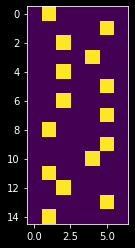

In [15]:
plt.imshow(s_nt.to_onehot())

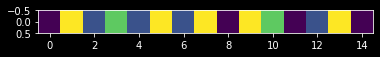

In [16]:

plt.imshow(np.atleast_2d(s_nt.to_index()))

### Quacking like SeqRecords

SeqLike objects, as we mentioned above, are highly inspired by SeqRecord objects.
This means that, if you're used to dealing with collections of SeqRecord objects,
you can actually access the underlying attributes easily via the same attribute accessors.
Here are a few examples.

#### Commonly-used SeqRecord attributes

In [17]:
s_nt

*** NT: SeqRecord(seq=Seq('AUCTCUCUAUTACUA'), id='ce9fd137-cfaa-4bce-9e50-10eb18132bc5', name='<unknown name>', description='<unknown description>', dbxrefs=[]) 

AA: None

In [18]:
s_nt.id

'ce9fd137-cfaa-4bce-9e50-10eb18132bc5'

In [19]:
s_nt.description

'<unknown description>'

In [20]:
s_nt.name

'<unknown name>'

In [21]:
s_nt.dbxrefs

[]

#### Letter annotations

Letter annotations are also accessible!

In [22]:
s_nt.letter_annotations

{'seqnums': ['1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15']}

They can also be set!
As long as the value fulfills the SeqRecord letter annotation requirement
of being a list of the same length as the main SeqRecord,
you can add to the `letter_annotations` attribute.
For example, if we want to add DNA methylation state:

In [23]:
len([
    None,
    None,
    "methylated",
    None,
    None,
    None,
    "methylated",
])# + [None] * 14)

7

In [24]:
s_nt.letter_annotations["methylation_state"] = [
    None,
    None,
    "methylated",
    None,
    None,
    None,
    "methylated",
] + [None] * 8

s_nt.letter_annotations

{'seqnums': ['1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15'],
 'methylation_state': [None,
  None,
  'methylated',
  None,
  None,
  None,
  'methylated',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None]}

SeqLike objects [quack like](https://en.wikipedia.org/wiki/Duck_test) SeqRecord objects.
We think that means you can take SeqRecord objects and replace them with SeqLike objects with no issue.
(But if you find an edge case we haven't yet covered, be sure to let us know!)

## Working with collections of SeqLikes in Pandas

SeqLike also aims to simplify common tasks when working with _collections_ of sequences.
We provide extensive integration with pandas Series via accessor methods,
making life supremely easy.

Accessor methods are exposed by the automatically generated `.seq` attribute in all pandas Series objects.  If a Series is all SeqLikes, then this namespace will contain many helpful methods for working with them.  Many operations return a new Series of SeqLikes, which added to a DataFrame as a new column and then futher manipulated by using `.seq`, again.

Let's say we have the following sequences:

In [25]:
seqs = [
    'LVSIPASSHGKRGLSVSIDPPHGPPGCGTEHSHTVRVQGVDPGCMSPDVKNSIHVGDRILEINGTPIRNVPLDEIDLLIQETSRLLQLTLE',
    'LISMPAATDGKRGFSVSVEGGCSSYATGVQVKEVNRMHISPDVRNAIHPADRILEINGAPIRTLQVEEVEDLIRKTSQTLQLLIE',
    'LISMPATTECRRGFSVSVESASSNYATTVQVKEVNRMHISPNNRNAIHPGDRILEINGTPVRTLRVEEVEDAINQTSQTLQLLIE',
    'SLKVSTSGELSGVGLQINVNPEVDVLEVILPLPGSPAEAAGIEAKDQILAIDGIDTRNIGLEEAAARMRGKKGSTVSLTVK',
    'SFNESINLSLEGIGTTLQSEDDEISIKSLVPGAPAERSKKLHPGDKIIGVGQATGDIEDVVGWRLEDLVEKIKGKKGTKVRLEIE',
    'NTEMSLSLEGIGAVLQMDDDYTVINSMVAGGPAAKSKAISVGDKIVGVGQTGKPMVDVIGWRLDDVVALIKGPKGSKVRLEIL',
    'QQLIEKGLVQRGWLGVQIQPVTKEISDSIGLKEAKGALITDPLKGPAAKAGIKAGDVIISVNGEKINDVRDLAKRIANMSPGETVTLGVW',
    'QQILEFGQVRRGLLGIKGGELNADLAKAFNVSAQQGAFVSEVLPKSAAEKAGLKAGDIITAMNGQKISSFAEIRAKIATTGAGKEISLTYL',
    'QLIDFGEIKRGLLGIKGTEMSADIAKAFNLDVQRGAFVSEVLPGSGSAKAGVKAGDIITSLNGKPLNSFAELRSRIATTEPGTKVKLGLL',
    'QMVEYGQVKRGELGIMGTELNSELAKAMKVDAQRGAFVSQVLPNSSAAKAGIKAGDVITSLNGKPISSFAALRAQVGTMPVGSKLTLGLL',
]

names = [
    'LIMK1_HUMAN/165-255',
    'LIMK2_CHICK/152-236',
    'LIMK2_RAT/152-236',
    'CTPA_SYNP2/102-182',
    'PRC_HAEIN/244-328',
    'PRC_ECOLI/238-320',
    'DEGPL_BARHE/289-378',
    'HTOA_HAEIN/268-358',
    'DEGQ_ECOLI/257-346',
    'DEGP_ECOLI/279-368',
]

df = pd.DataFrame({'names':names, 'aa_seqs':[aaSeqLike(x) for x in seqs]})
df

,names,aa_seqs
0,LIMK1_HUMAN/165-255,"(L, V, S, I, P, A, S, S, H, G, K, R, G, L, S, ..."
1,LIMK2_CHICK/152-236,"(L, I, S, M, P, A, A, T, D, G, K, R, G, F, S, ..."
2,LIMK2_RAT/152-236,"(L, I, S, M, P, A, T, T, E, C, R, R, G, F, S, ..."
3,CTPA_SYNP2/102-182,"(S, L, K, V, S, T, S, G, E, L, S, G, V, G, L, ..."
4,PRC_HAEIN/244-328,"(S, F, N, E, S, I, N, L, S, L, E, G, I, G, T, ..."
5,PRC_ECOLI/238-320,"(N, T, E, M, S, L, S, L, E, G, I, G, A, V, L, ..."
6,DEGPL_BARHE/289-378,"(Q, Q, L, I, E, K, G, L, V, Q, R, G, W, L, G, ..."
7,HTOA_HAEIN/268-358,"(Q, Q, I, L, E, F, G, Q, V, R, R, G, L, L, G, ..."
8,DEGQ_ECOLI/257-346,"(Q, L, I, D, F, G, E, I, K, R, G, L, L, G, I, ..."
9,DEGP_ECOLI/279-368,"(Q, M, V, E, Y, G, Q, V, K, R, G, E, L, G, I, ..."


### Plotting

Plotting is _dead simple_.

In [26]:
df["aa_seqs"].seq.plot()

Column(id='1087', ...)

### Conversion between NT and AA

Just as with single sequences, you can easily convert between AA and NT forms in dataframes:

In [27]:
# backtranslation returns a Series of nt SeqLikes
df['nt_seqs'] = df["aa_seqs"].seq.back_translate(codon_map=human_codon_map)
df['nt_seqs'].seq.plot()

Column(id='1270', ...)

### Creating Multiple Sequence Alignments

Traditionally, multiple sequence alignments are a hassle:
you have to export the sequence collection to a FASTA file,
run a command line program that exports a text file,
and then read back the text file into Python.
With SeqLike, you have access to MAFFT to do multiple sequence alignments quickly and easily.

In [28]:
df["aa_seqs"].seq.align().seq.plot()

Column(id='1469', ...)

In [29]:
df["nt_seqs"].seq.align().seq.plot()

Column(id='1684', ...)

### Bulk conversion to array forms

Just as with single SeqLikes, we can convert a collection of SeqLikes
in a Pandas series into their array form.  The sequences are collated along the first (0th) axis.
They need not necessarily be pre-aligned, because padding happens by default.   These methods return NumPy arrays, which can be manipulated and viewed as normal.  Here we also plot an aligned, index encoded collection of sequences in matplotlib.

df['aa_seqs'].seq.to_onehot().shape=(10, 91, 23)


(-0.5, 311.5, 9.5, -0.5)

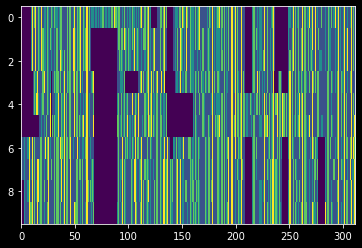

In [30]:
# This works for AA SeqLikes...
print(f"{df['aa_seqs'].seq.to_onehot().shape=}") # (num_sequences x length x aa alphabet size)

plt.imshow(df["nt_seqs"].seq.align().seq.to_index())
plt.axis('tight')